# Fraudulent Transaction Predictions

#### Predict if a transaction made from sender to recepient is fradulent or not

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import autoreload
import matplotlib.pyplot as plt
import missingno as msno
import csv
import os
import sys

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

sb.set_style('darkgrid')

%matplotlib inline

#### Load dataset from host machine

In [2]:
df = pd.read_csv("D:\Open Classroom\Datasets\Fraudulent Transactions Prediction\Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### About the Dataset
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. amount - amount of the transaction in local currency.

4. nameOrig - customer who started the transaction

5. oldbalanceOrg - initial balance before the transaction

6. newbalanceOrig - new balance after the transaction

7. nameDest - customer who is the recipient of the transaction

8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



#### Statistical representation of the dataset

In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Graphical Presentation

Text(0.5, 1, 'Pearsons Correlation of columns')

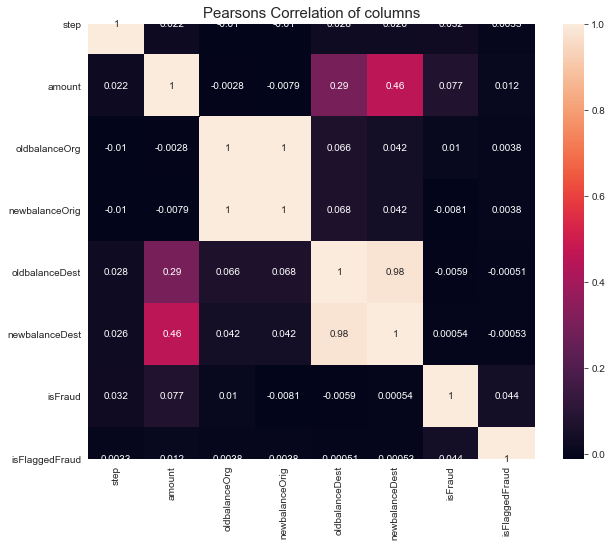

In [7]:
plt.figure(figsize = (10,8))
sb.heatmap(df.corr(), annot = True)
plt.title('Pearsons Correlation of columns', fontsize = (15))

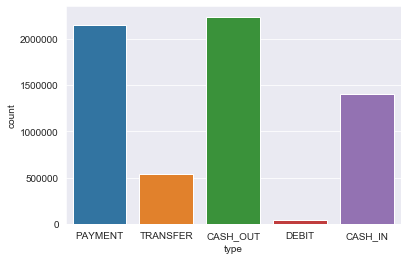

In [8]:
sb.countplot(df['type'])

0    99.87
1     0.13
Name: isFraud, dtype: float64

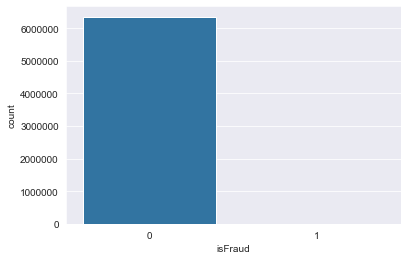

In [9]:
sb.countplot(df["isFraud"])
round(df.isFraud.value_counts(normalize = True)*100, 2)

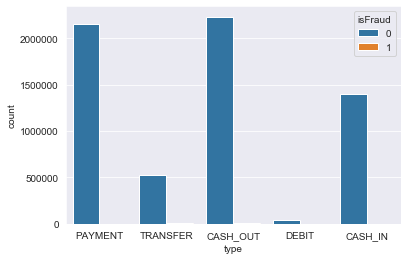

In [10]:
sb.countplot(df['type'], hue = "isFraud", data = df)

In [11]:
type_vs_isfraud = df.groupby('type')
type_vs_isfraud['isFraud'].value_counts().to_frame().rename(columns={'isFraud':'count'}).T

type     CASH_IN CASH_OUT        DEBIT  PAYMENT TRANSFER      
isFraud        0        0     1      0        0        0     1
count    1399284  2233384  4116  41432  2151495   528812  4097

#### Feature Engineering

Use label encoder to tranform text columns to numerals parameters

In [12]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [13]:
df.drop(columns = ["nameOrig", "nameDest", "isFlaggedFraud"], inplace = True)

In [14]:
le = LabelEncoder() # Create instance of encoder

In [15]:
df['type'] = le.fit_transform(df['type'])
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


#### Evaluate and Train the Dataset

In [16]:
x = df.drop(columns = ['isFraud']) # Predictor Variable 
y = df['isFraud'] # Target variable (outcome)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x train :', x_train.shape)
print('x test :', x_test.shape)
print('y train :', y_train.shape)
print('y test :', y_test.shape)

x train : (5090096, 7)
x test : (1272524, 7)
y train : (5090096,)
y test : (1272524,)


#### Create Predictive Model

#### 1. Decision Tree Model

In [17]:
dtc = DecisionTreeClassifier()

In [18]:
dtc.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [19]:
pred = dtc.predict(x_train)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
acc_score = accuracy_score(y_train, pred)
print('Accuracy score: ', acc_score)

Accuracy score:  1.0


In [21]:
print(confusion_matrix(y_train, pred))

[[5083553       0]
 [      0    6543]]


In [22]:
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083553
           1       1.00      1.00      1.00      6543

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

